# Практическое задание к уроку "Сегментация"

1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Можете взять один из этих наборов данных:
- https://www.kaggle.com/carlolepelaars/camvid
- https://www.kaggle.com/dansbecker/cityscapes-image-pairs
- https://www.kaggle.com/tapakah68/segmentation-full-body-mads-dataset
- https://www.kaggle.com/longnguyen2306/bacteria-detection-with-darkfield-microscopy
- https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels
2. Опишите в комментарии - какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?

Выбран датасет: https://www.kaggle.com/dansbecker/cityscapes-image-pairs

In [71]:
import numpy as np

In [72]:
from pathlib import Path
from keras.preprocessing import image

path_train = './data/cityscapes_data/train/'
path_validation = './data/cityscapes_data/val/'

train_images_paths = list(Path(path_train).iterdir())

In [73]:
single_image = image.load_img(train_images_paths[0])
image_size = (int(single_image.size[0]/2), single_image.size[1])
image_size

(256, 256)

In [74]:
images = []
masks = []
for path in train_images_paths:
    temp_img = image.load_img(path) 
    img = temp_img.crop((0, 0, image_size[0], image_size[1])) 
    mask = temp_img.crop((image_size[0], 0, image_size[0] * 2, image_size[1]))
    images.append(img)
    masks.append(mask)

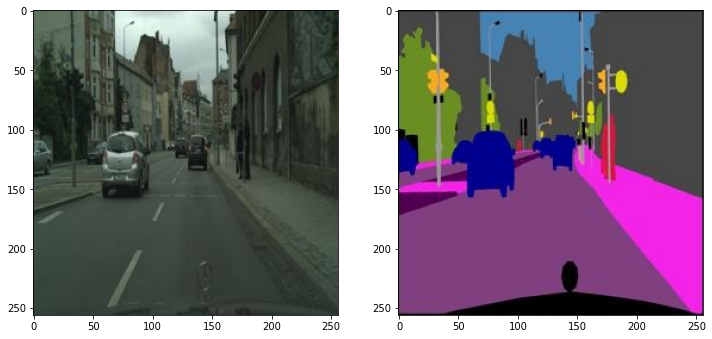

In [75]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(images[80].convert('RGBA'))
ax[1].imshow(masks[80].convert('RGBA'))

In [147]:
def extract_classes_from_masks(masks, gradations_number=3):
    classes = set()
    max_color_value = 255
    color_group_divider = int(max_color_value / gradations_number) 

    for mask in masks:
        for pixel in masks[0].convert('RGBA').getdata():
            r = int(pixel[0] / color_group_divider) * color_group_divider
            g = int(pixel[1] / color_group_divider) * color_group_divider
            b = int(pixel[2] / color_group_divider) * color_group_divider
            classes.add((r, g, b,))

    return [[item[0], item[1], item[2]] for item in list(classes)]


In [ ]:
classes = extract_classes_from_masks(masks, 3)

In [76]:
X = []

for img in images:
    x = image.img_to_array(img)
    X.append(x)

X = np.array(X)

(2975, 256, 256, 3)


In [107]:
import cv2

def Color2index(y, classes):
    y_ind = np.zeros((y.shape[0], y.shape[1]))
    y_cat = np.zeros((y.shape[0], y.shape[1], len(classes)))
    i = 1
    for color in classes:
        ind_i = np.where(
            (y[..., 0] == color[0]) 
            & (y[..., 1] == color[1])
            & (y[..., 2] == color[2])
        )
        y_ind[ind_i[0], ind_i[1]] = i
        y_cat[ind_i[0], ind_i[1], i-1] = 1 
        i += 1
    
    return y_cat, y_ind

In [2]:
from keras.models import Model
from keras.layers import (Activation, Input, MaxPooling2D, BatchNormalization, 
                          Conv2D, Conv2DTranspose, concatenate)
from tensorflow.keras.utils import plot_model

def Unet(num_classes=30, input_shape=(256, 512, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)


    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)


    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)


    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

 
    # UP 1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    return model

In [3]:
import keras.backend as K

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred)) / (K.sum(y_true) + K.sum(y_pred))

In [4]:
import tensorflow
from tensorflow.keras.optimizers import Adam

model = Unet()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 512, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 512, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
history = model.fit(X_train, y_train,
                      epochs=20,
                      batch_size=1,
                      validation_data=(X_test, y_test),
                      callbacks=[DisplayCallback(patience=5)])

NameError: name 'X_train' is not defined